In [135]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# считаем данные
df = pd.read_csv("data/ghana_gdp.csv",parse_dates=['year'], index_col=['year']) # считываем датасет
df.head() 

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


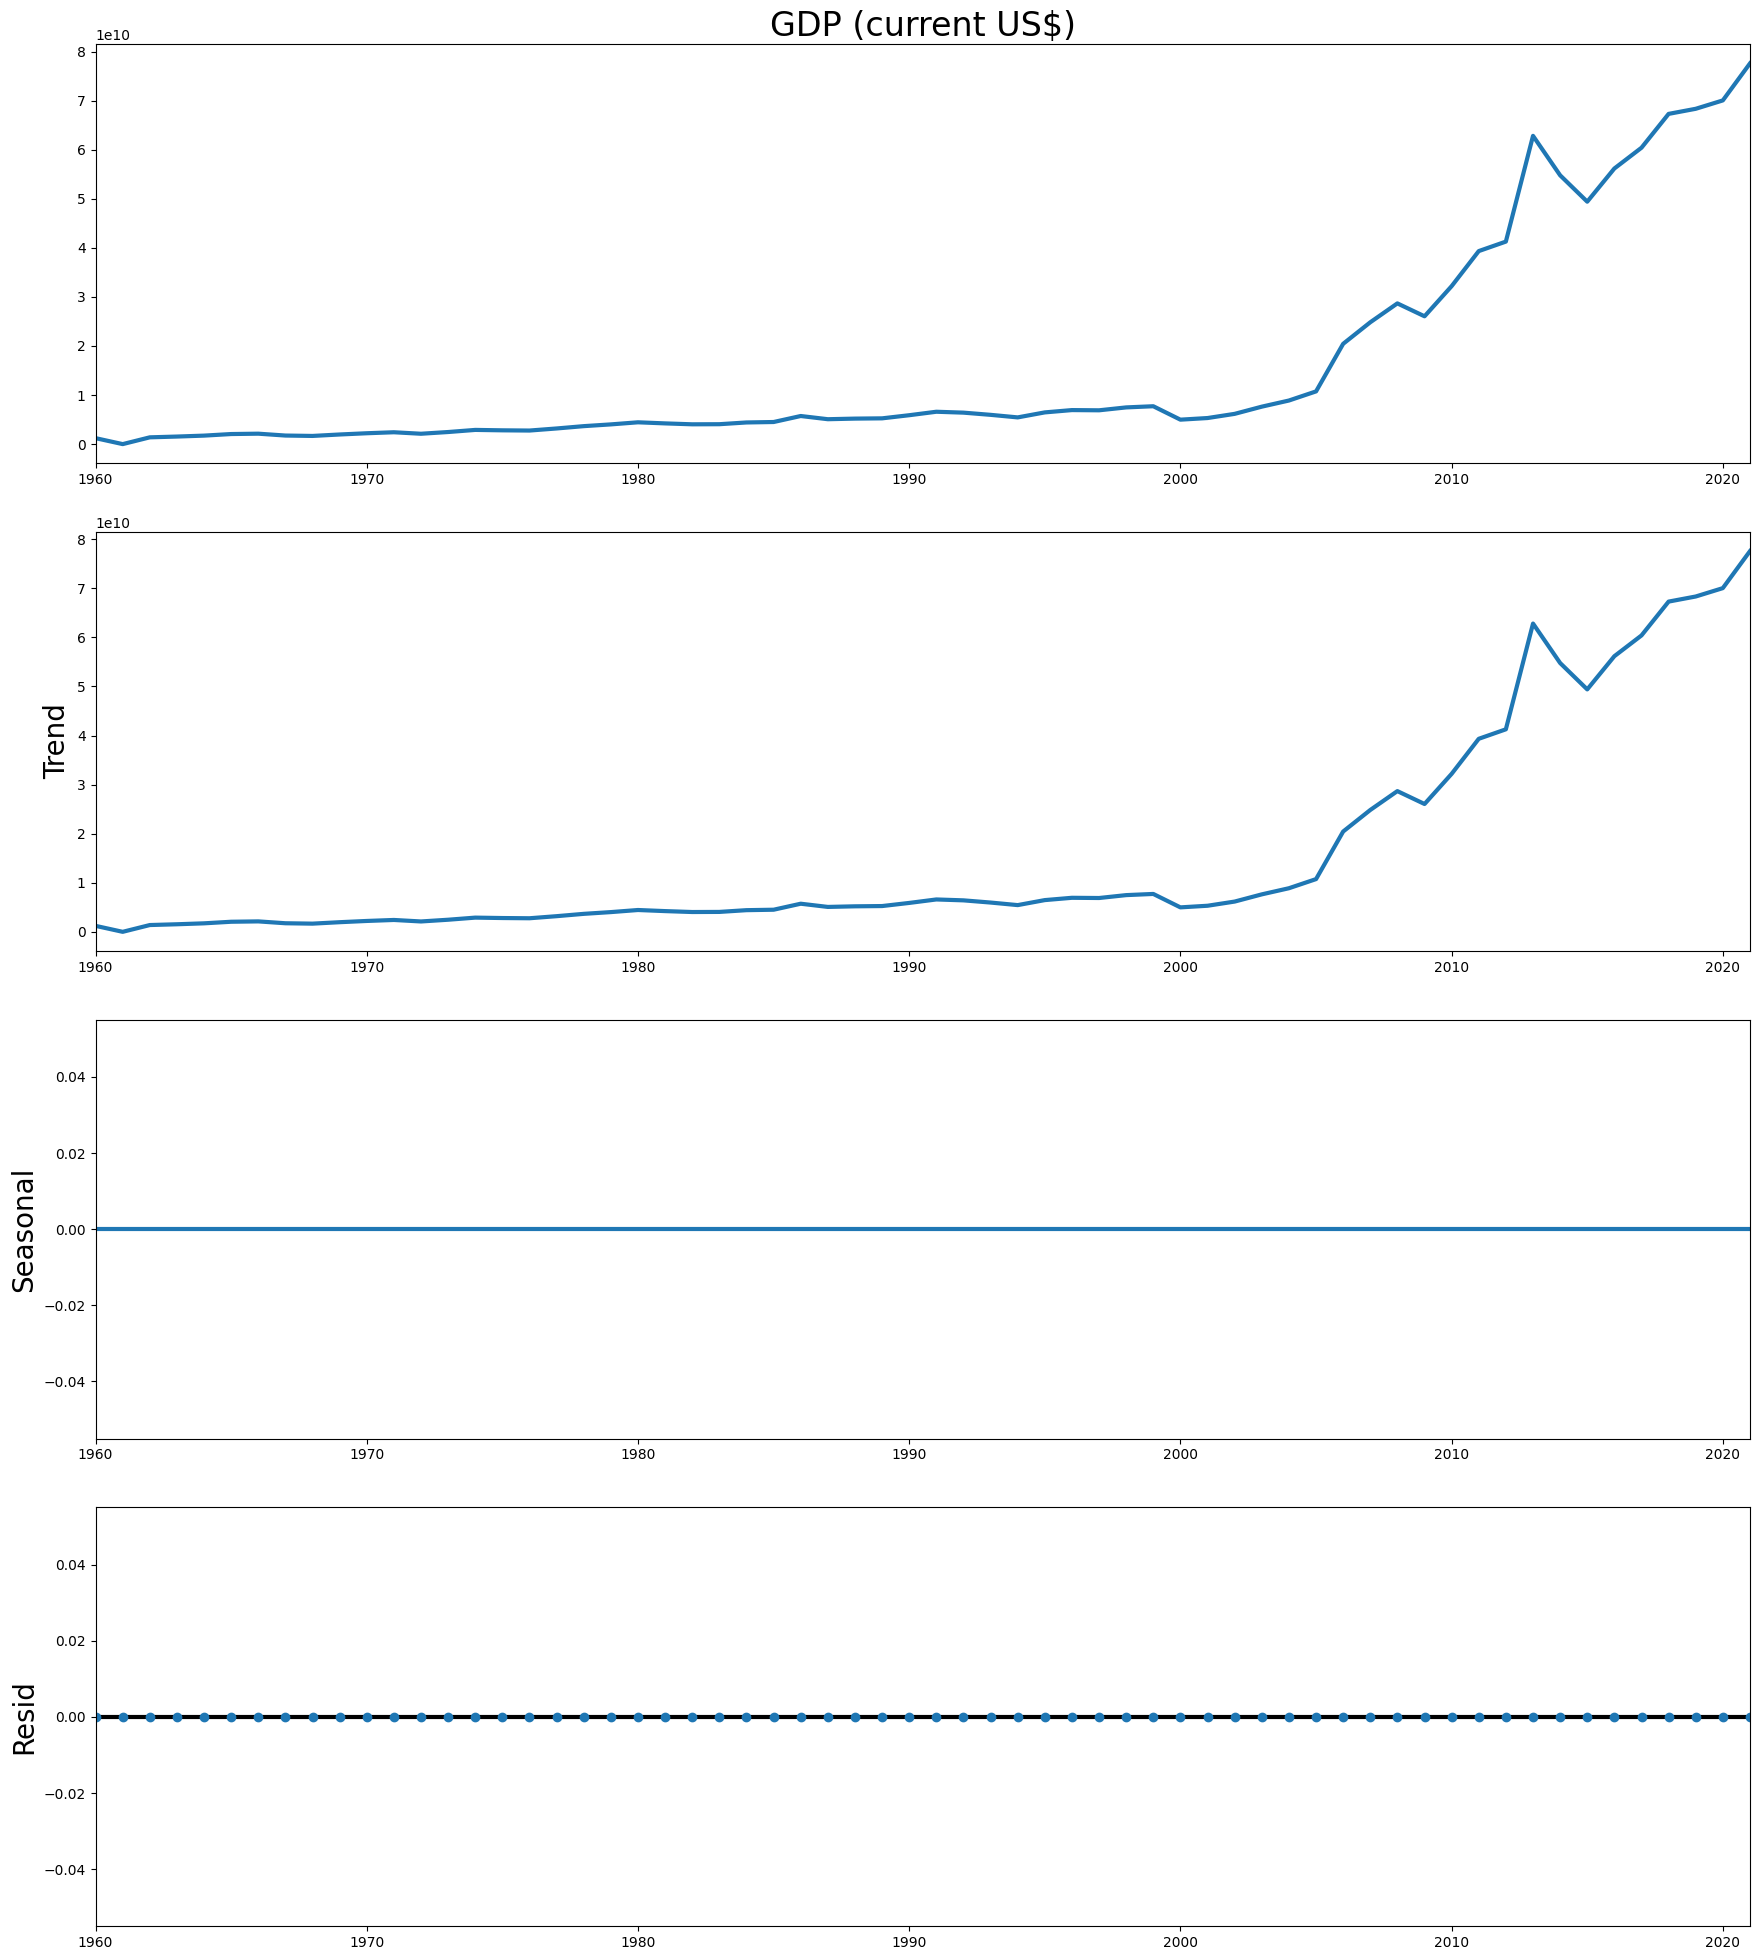

In [136]:
# разложим временной ряд на составляющие, оценим визуализацию
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(df['GDP (current US$)'])
result.plot()
plt.show()

Сезонность не прослеживается, что логично, т.к. отсутствует явно повторяющийся период 
вроде сезонов года или дней недели.

Сезонная декомпозиция показывает, что вся динамика обусловлена трендом.

In [137]:
# выделим тестовую часть в размере трех последних наблюдений
train_df = df.loc[:"2018-01-01"]
test_df = df.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

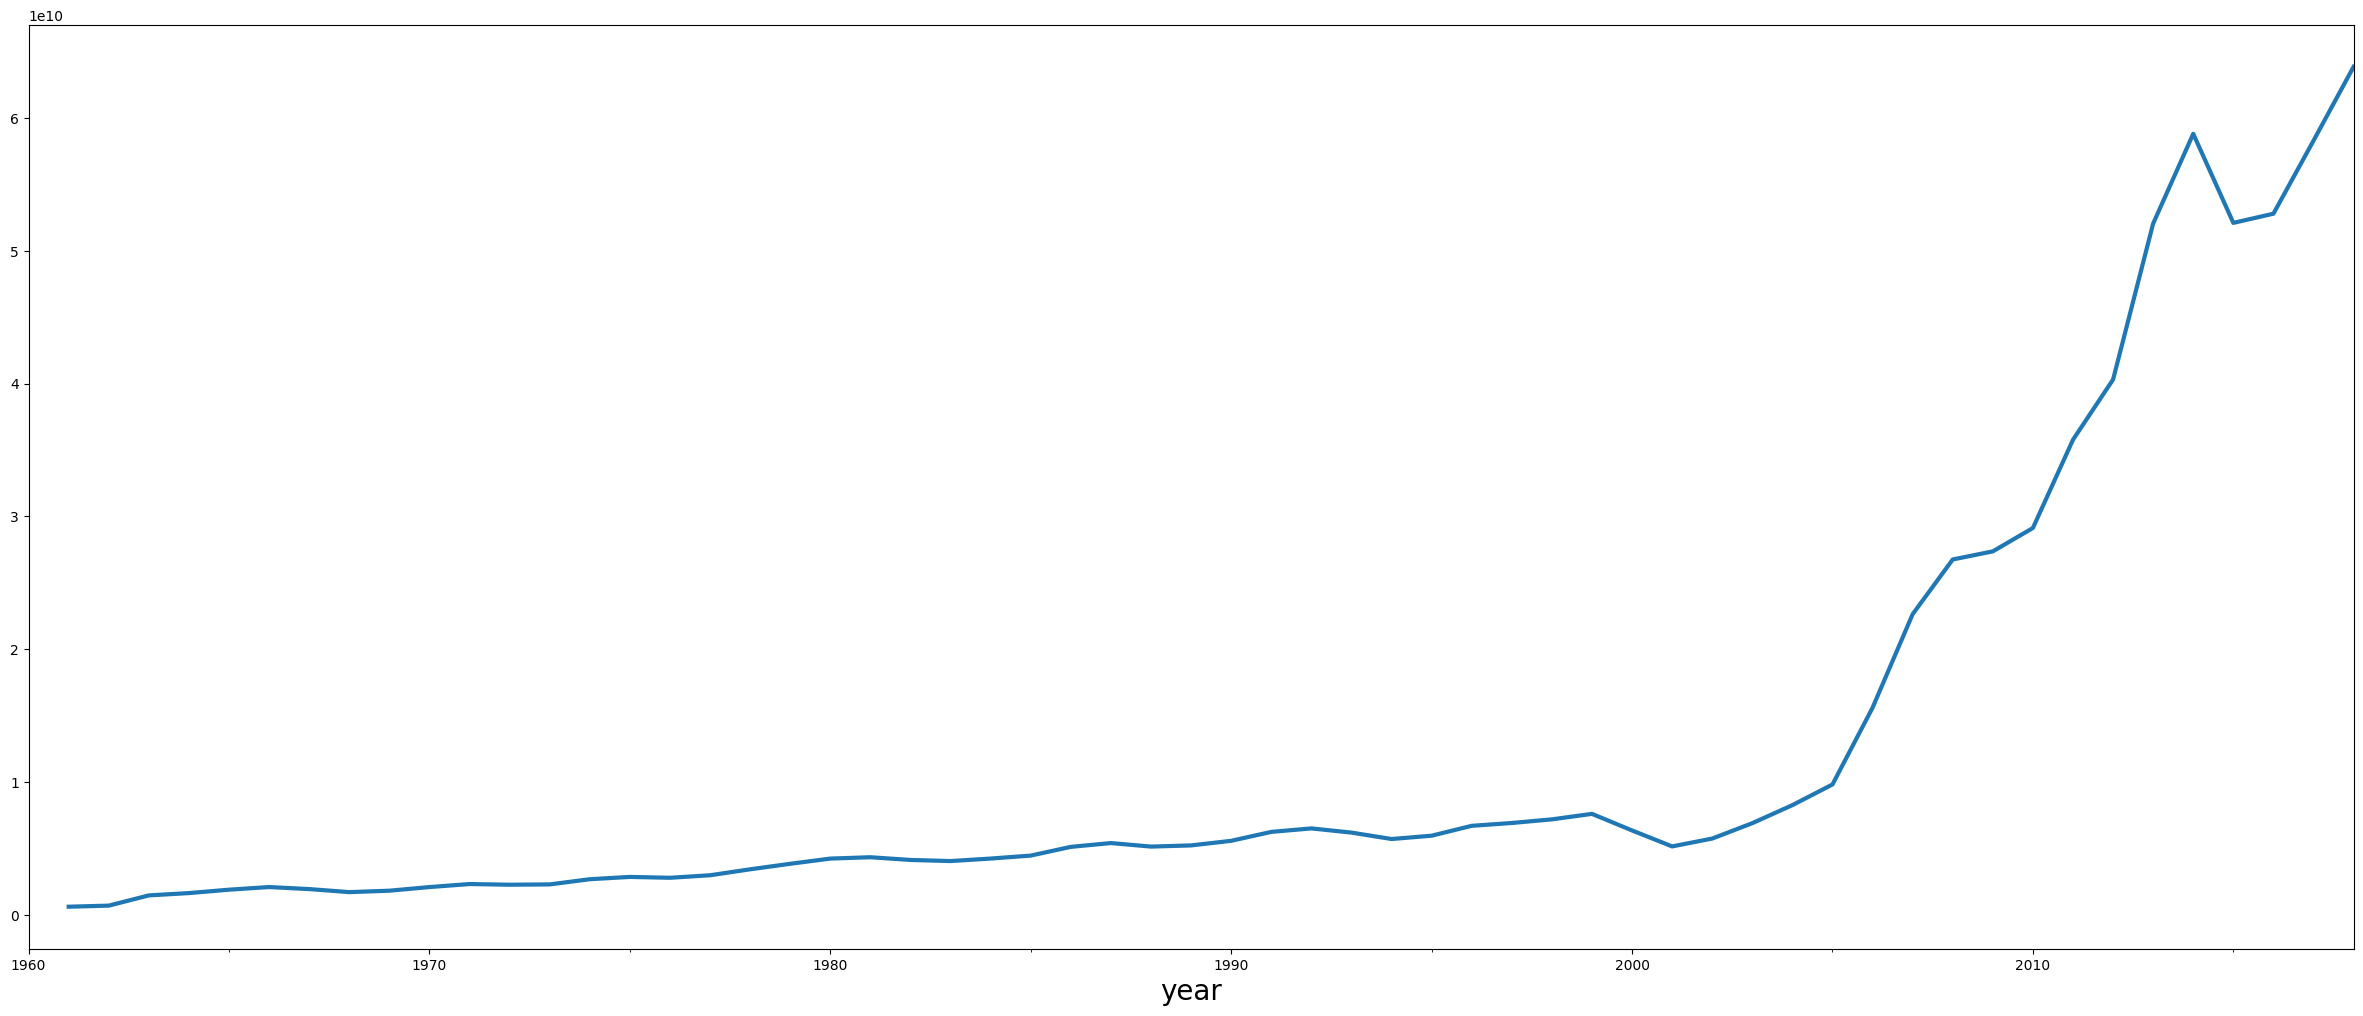

In [138]:
# построим график скользящего среднего с окном 2
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

train_df['GDP (current US$)'].rolling(window=2).mean().plot()
plt.show()

Окно достаточно маленькой ширины незначительно сгладило острый пик в последней четверти графика.

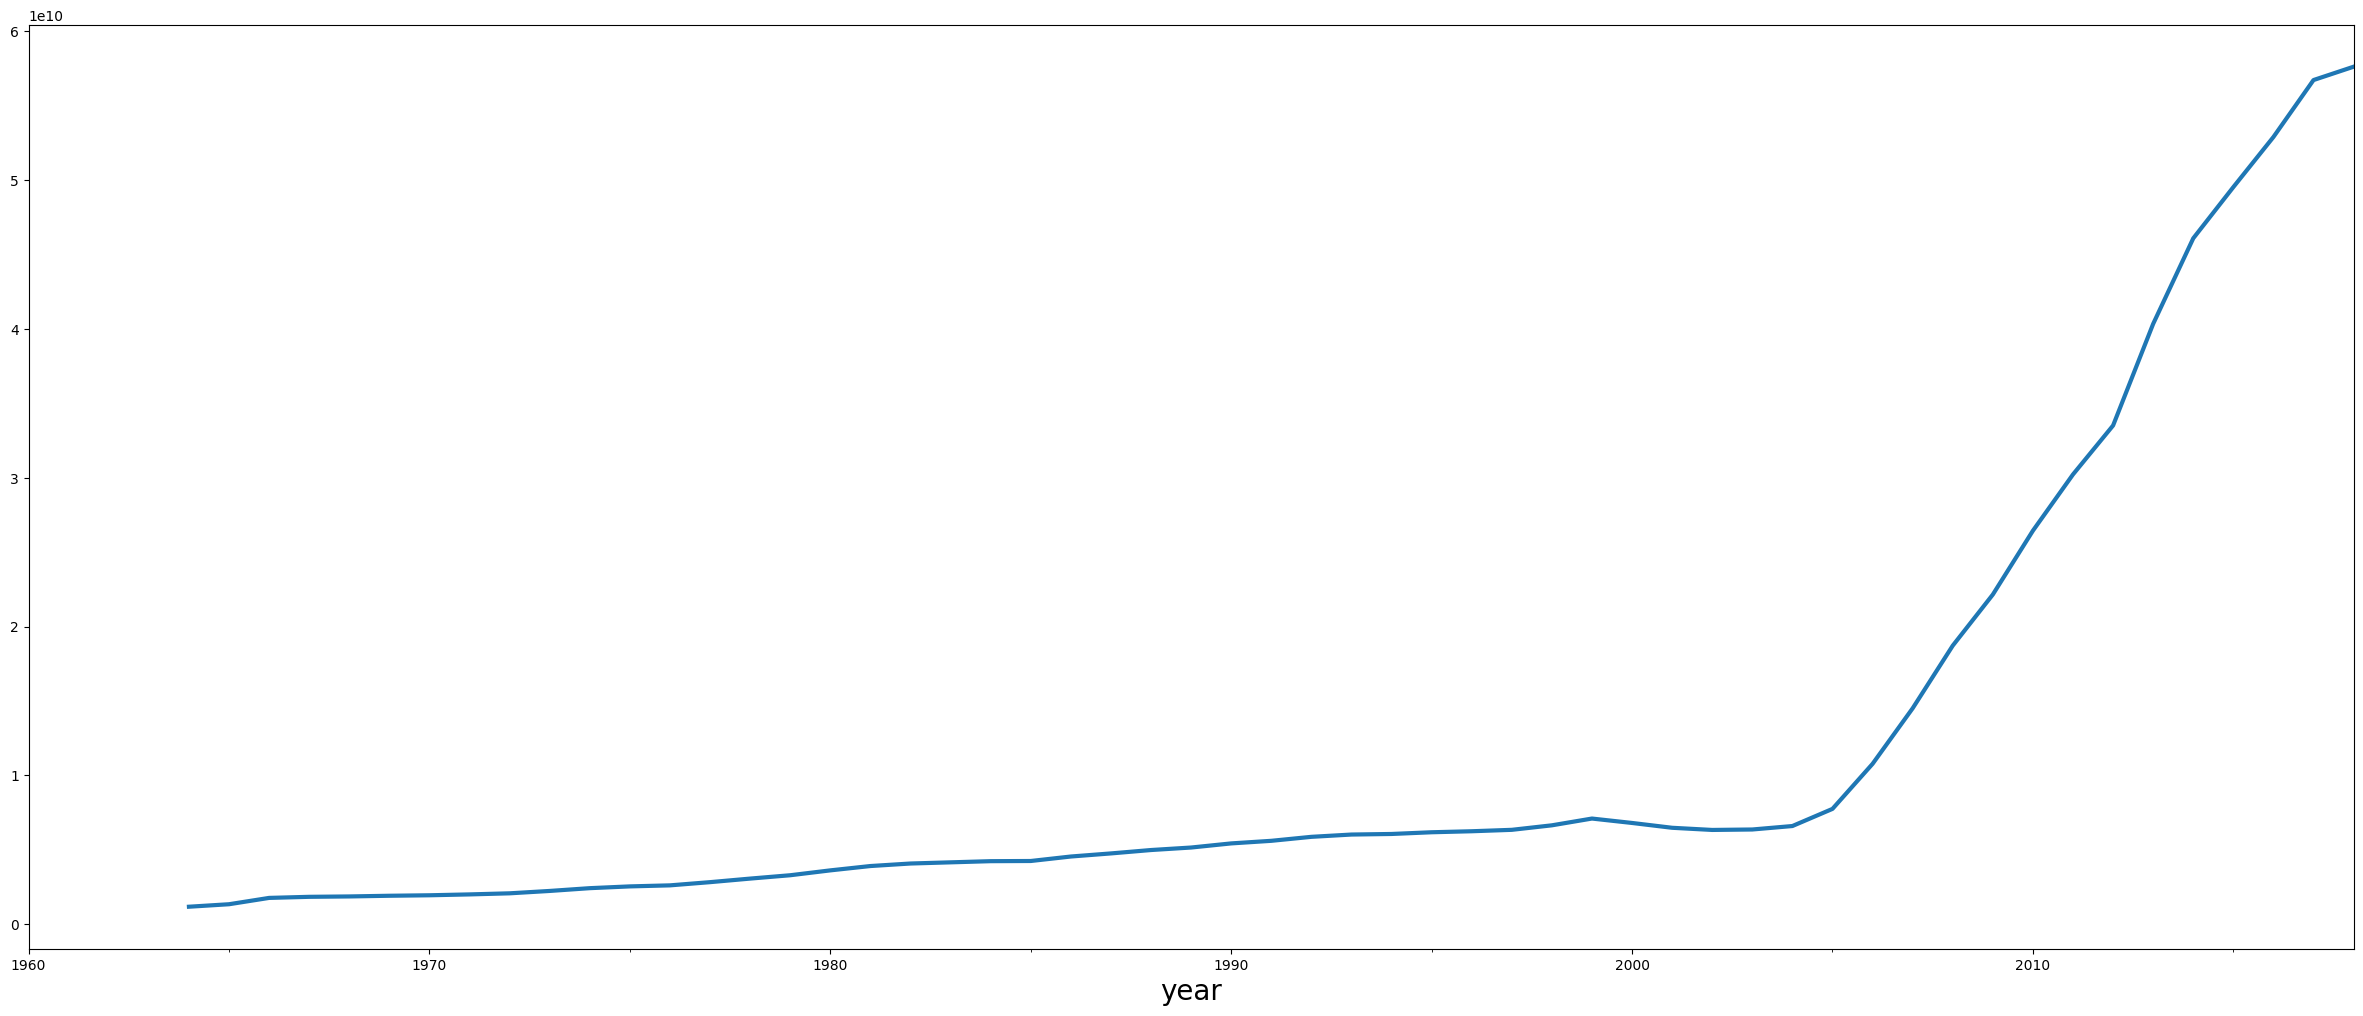

In [139]:
# сделаем окно пошире, осредним 5 соседних значений
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

train_df['GDP (current US$)'].rolling(window=5).mean().plot()
plt.show()

В результате вычисления скользящего среднего с окном 5 пики ушли, осталась гладкая кривая, 
которая в большей степени выглядит как тренд, сглаженная тенденция.

In [140]:
# проведем тест Дики-Фуллера

result = adfuller(train_df["GDP (current US$)"])

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")

for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")

ADF Statistic: 0.65290669748854
p-value: 0.9888496277665573
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600


Вывод: значение статистики больше критических значений, ряд нестационарный.


Учитывая, что мы не привлекаем экзогенные переменные, а сезонность отсутствует, 

будем использовать для прогноза модель ARIMA.

In [141]:
# дифференцируем ряд для определения порядка интегрированного ряда
train_df_diff_1 = train_df.diff().dropna()

In [142]:
# посредством теста Дики-Фуллера проверим первую разность ряда на стационарность
test1 = adfuller(train_df_diff_1)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -1.6702483038320752
p-value:  0.44650293297139043
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен


In [143]:
# проведем дифференцирование второй раз
train_df_diff_2 = train_df_diff_1.diff().dropna()

In [144]:
# посредством теста Дики-Фуллера проверим вторую разность ряда на стационарность
test2 = adfuller(train_df_diff_2)
print ('adf: ', test2[0])
print ('p-value: ', test2[1])
print ('Critical values: ', test2[4])
if test2[0]> test2[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -2.640869056128489
p-value:  0.08484116917837686
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен


In [145]:
# проведем дифференцирование третий раз
train_df_diff_3 = train_df_diff_2.diff().dropna()

In [146]:
# посредством теста Дики-Фуллера проверим третью разность ряда на стационарность
test3 = adfuller(train_df_diff_3)
print ('adf: ', test3[0])
print ('p-value: ', test3[1])
print ('Critical values: ', test3[4])
if test3[0]> test3[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -4.779623784828548
p-value:  5.948327640224507e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен


Вывод: исходная последовательность является интегрированным рядом третьего порядка.

Т.е., в модели ARIMA параметр d принимает значение = 3.

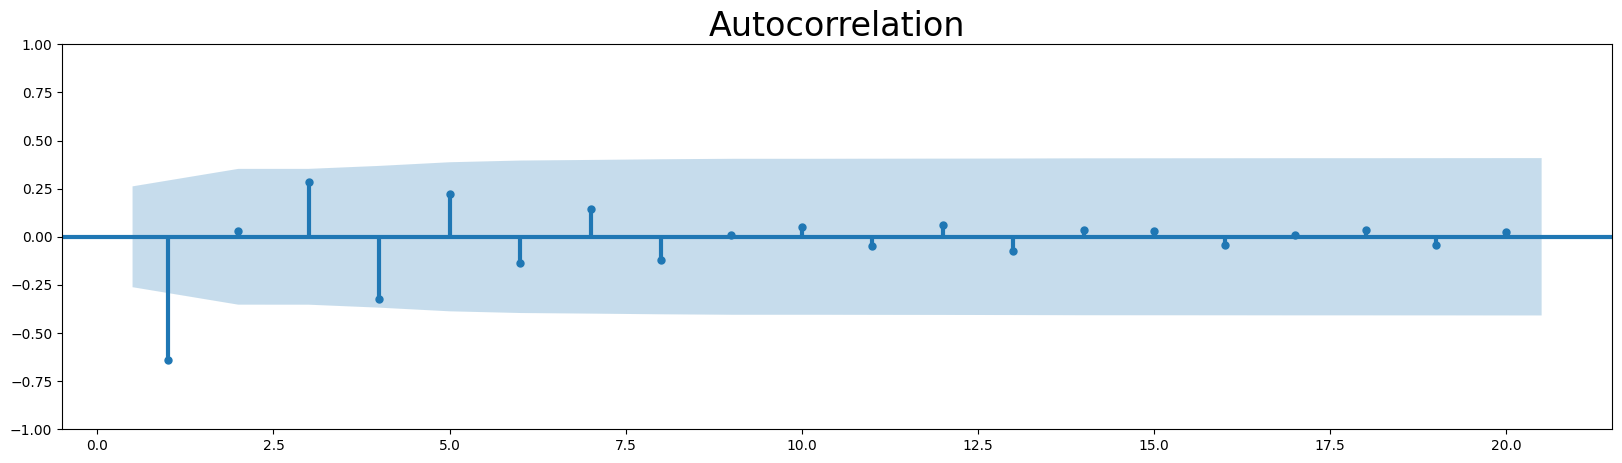

In [147]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df_diff_3, lags=20, zero=False)
plt.show()

Вывод: параметр q берем со значением 1

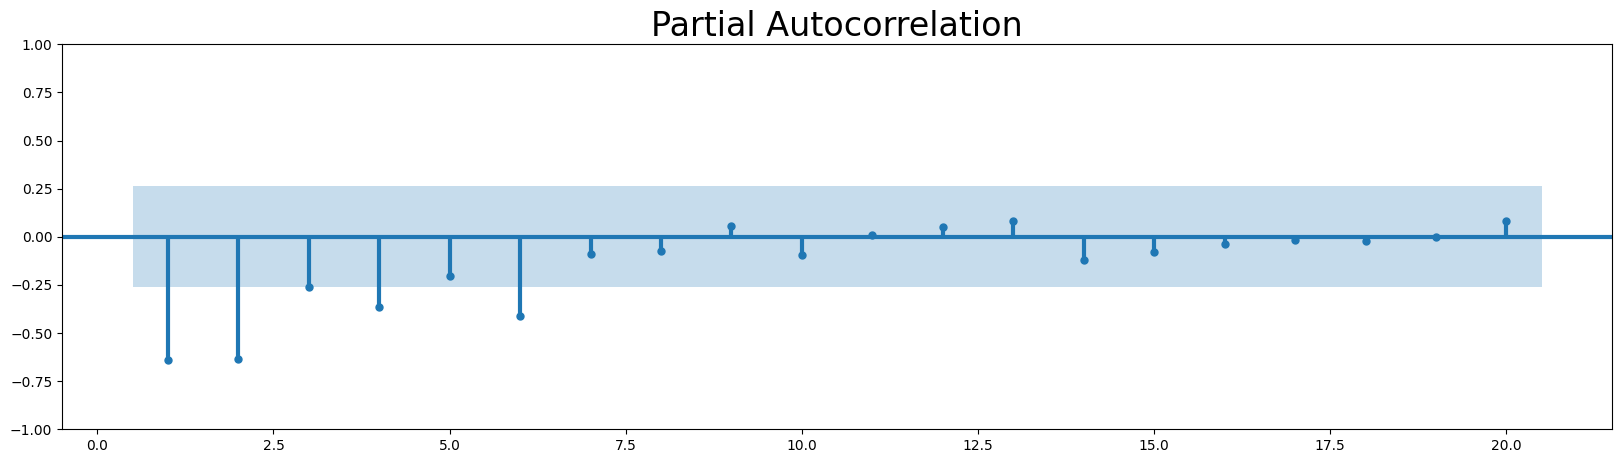

In [148]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df_diff_3, lags=20, method="ywm", zero=False)
plt.show()

Вывод: параметр p берем со значением 2

In [149]:
# Строим модель ARIMA с подобранными параметрами
arima_model = ARIMA(train_df_diff_3.dropna(), order=(2, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   56
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1312.668
Date:                Sat, 14 Oct 2023   AIC                           2633.335
Time:                        14:48:19   BIC                           2641.216
Sample:                    01-01-1963   HQIC                          2636.366
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3933      0.057    -24.368      0.000      -1.505      -1.281
ar.L2         -0.8436      0.047    -17.964      0.000      -0.936      -0.752
ma.L1         -0.9722      0.196     -4.952      0.000      -1.357      -0.587
sigma2      2.683e+20   3.84e-22   6.99e+41      0.000    2.68e+20    2.68e+20
===================================================================================
Ljung-Box (L1) (Q):                   3.85   Jarque-Bera (JB):                54.05
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):             163.71   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.68e+58. Standard errors may be unstable.
"""

In [150]:
# подберем лучшие параметры на основании значений AIC
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=3,
    max_q=7,
    D=1,
    P=0,
    Q=0,
    m=1,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.25 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.04 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.07 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.03 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.08 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.04 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.06 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 1.178 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Sat, 14 Oct 2023   AIC                           2659.231
Time:                        14:48:20   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.32e+56. Standard errors may be unstable.
"""

Вывод: лучший набор параметров модели ARIMA (p, d, q) выглядит как (2, 3, 1)

Построим модель с наилучшими параметрами и выполним предсказание для отложенной тестовой выборки (последние три года).

In [151]:
arima_model = ARIMA(train_df.dropna(), order=(2, 3, 1))
arima_model_fit = arima_model.fit()
pred = arima_model_fit.get_prediction(start=test_df.index[0], end=test_df.index[-1], dynamic=False)
pred.predicted_mean

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


2019-01-01    7.368591e+10
2020-01-01    7.954567e+10
2021-01-01    8.633936e+10
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [152]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df["GDP (current US$)"] = df["GDP (current US$)"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

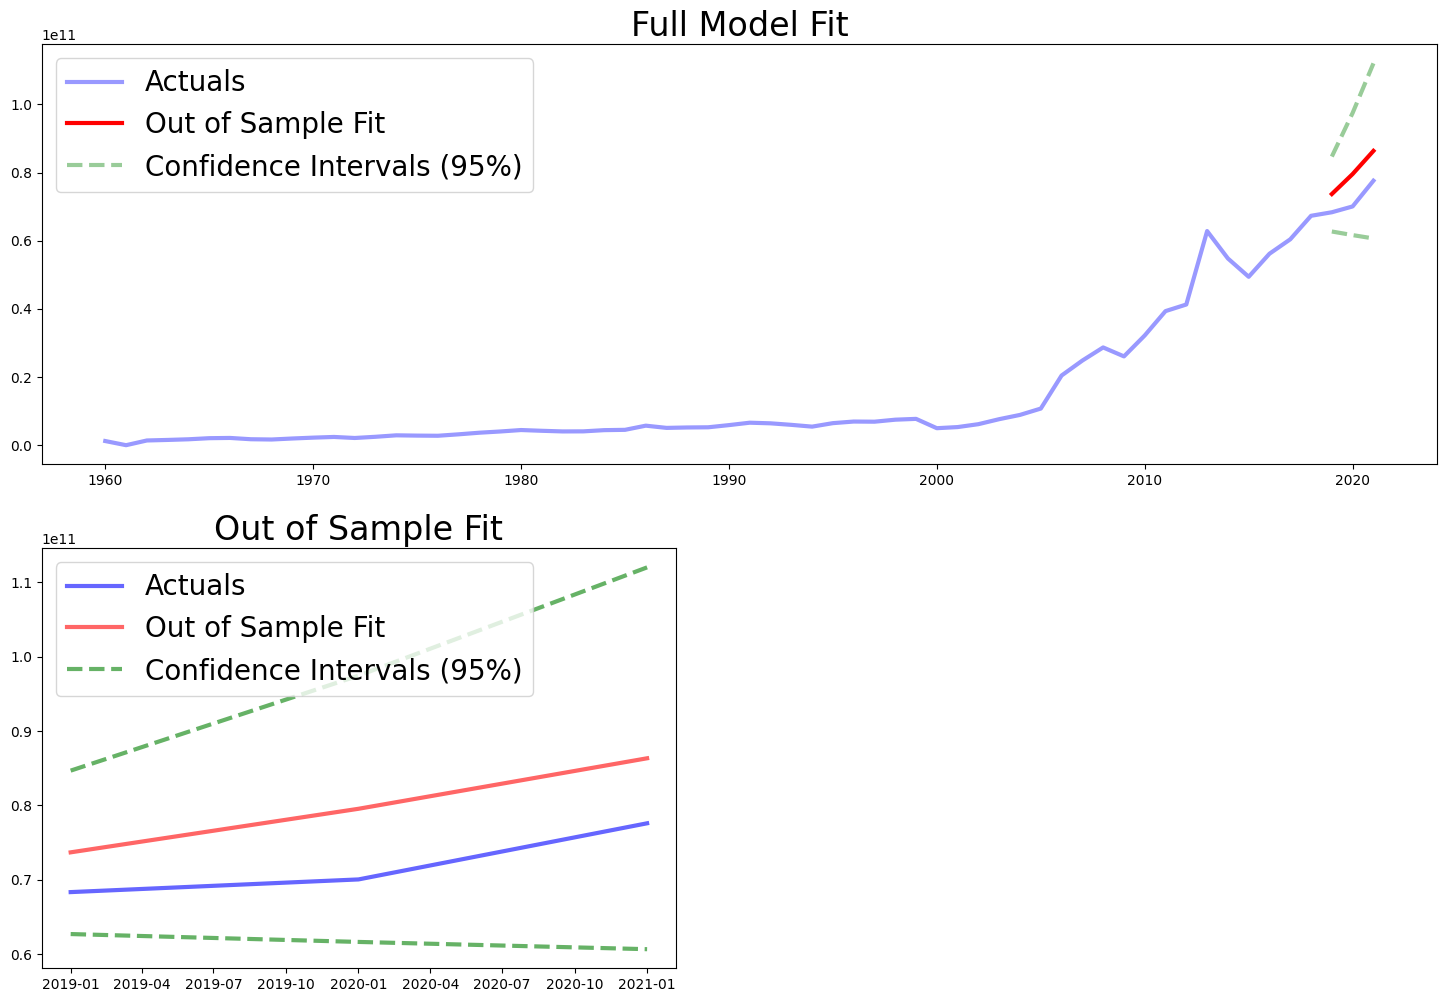

In [153]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Вывод. Предсказание модели не совпало с фактическими данными, но при этом выглядит достаточно достоверно. 

Следует отметить, что фактические данные полностью находятся в доверительном 95%-м интервале.

# Интерполяция и сэмплирование

In [154]:
df.shape

(62, 1)

In [155]:
df.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [156]:
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)
df['GDP (current US$)'].isna().sum()

1

In [157]:
df['GDP (current US$)'] = df['GDP (current US$)'].interpolate(method='linear')

In [158]:
# выделим тестовую часть в размере трех последних наблюдений
train_df = df.loc[:"2018-01-01"]
test_df = df.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [159]:
# проведем тест Дики-Фуллера

result = adfuller(train_df["GDP (current US$)"])

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")

for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")
 
if result[0]> result[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

ADF Statistic: 0.8030073326980106
p-value: 0.9916845572455877
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600
ряд нестационарен


Вывод: значение статистики больше критических значений, ряд нестационарный.


Учитывая, что мы не привлекаем экзогенные переменные, а сезонность отсутствует, 

будем использовать для прогноза модель ARIMA.

In [160]:
# дифференцируем ряд для определения порядка интегрированного ряда
train_df_diff_1 = train_df.diff().dropna()

# посредством теста Дики-Фуллера проверим первую разность ряда на стационарность
test1 = adfuller(train_df_diff_1)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -1.8255652246435983
p-value:  0.36784515276563506
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен


In [161]:
# проведем дифференцирование второй раз
train_df_diff_2 = train_df_diff_1.diff().dropna()

# посредством теста Дики-Фуллера проверим вторую разность ряда на стационарность
test2 = adfuller(train_df_diff_2)
print ('adf: ', test2[0])
print ('p-value: ', test2[1])
print ('Critical values: ', test2[4])
if test2[0]> test2[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -2.6346347460078476
p-value:  0.08604813722197568
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен


In [162]:
# проведем дифференцирование третий раз
train_df_diff_3 = train_df_diff_2.diff().dropna()

# посредством теста Дики-Фуллера проверим третью разность ряда на стационарность
test3 = adfuller(train_df_diff_3)
print ('adf: ', test3[0])
print ('p-value: ', test3[1])
print ('Critical values: ', test3[4])
if test3[0]> test3[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -4.825603687304055
p-value:  4.857318076799231e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен


Вывод: исходная последовательность является интегрированным рядом третьего порядка.

Т.е., в модели ARIMA параметр d принимает значение = 3.

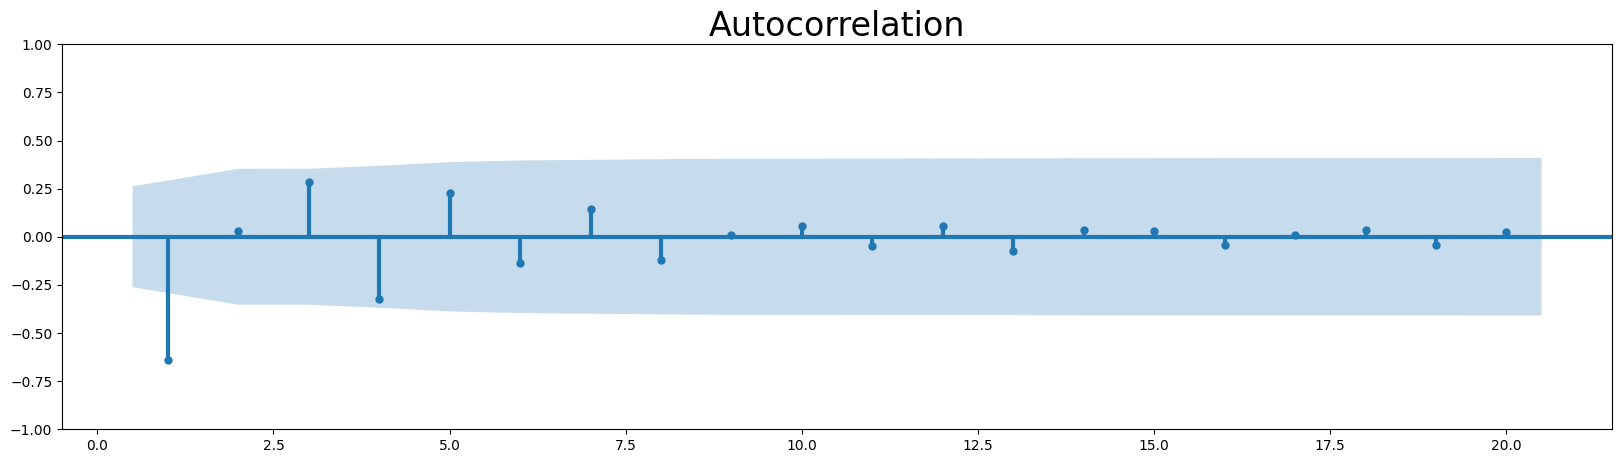

In [163]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df_diff_3, lags=20, zero=False)
plt.show()

Вывод: параметр q берем со значением 1

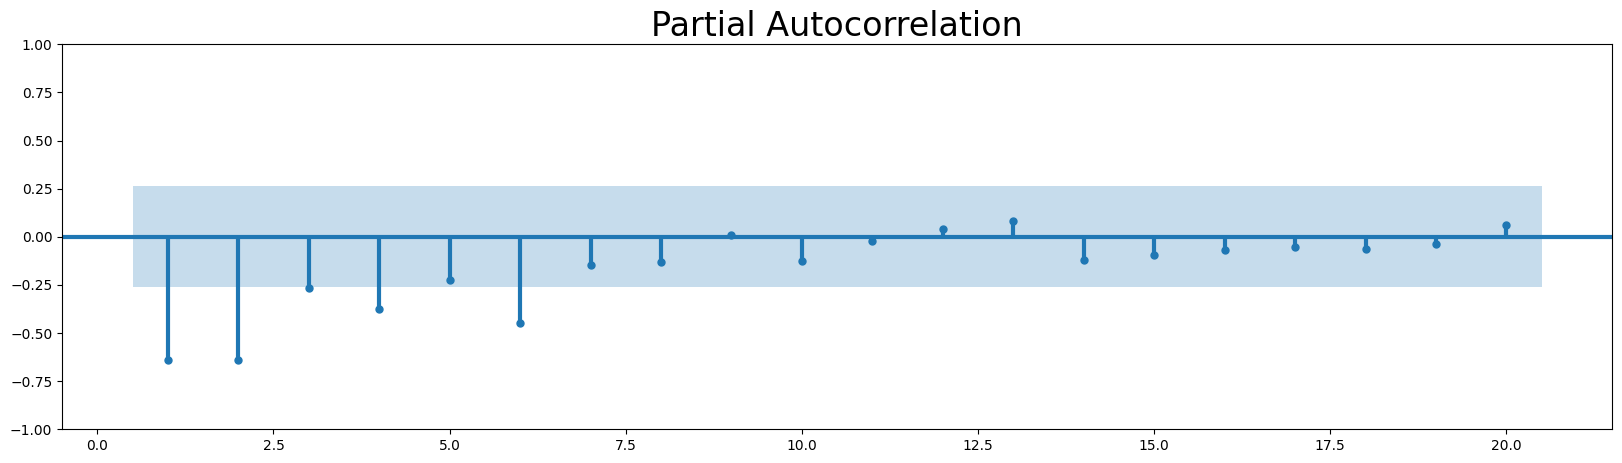

In [164]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df_diff_3, lags=20, method="ywm", zero=False)
plt.show()

Вывод: параметр p берем со значением 2

In [165]:
# подберем лучшие параметры на основании значений AIC
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=7,
    max_q=7,
    D=1,
    P=0,
    Q=0,
    m=1,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.16 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.03 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.05 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.06 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.03 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.09 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.04 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.05 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 1.053 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Sat, 14 Oct 2023   AIC                           2659.226
Time:                        14:48:23   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Вывод: лучший набор параметров модели ARIMA (p, d, q) выглядит как (2, 3, 1)

In [166]:
# Строим модель ARIMA с подобранными параметрами
arima_model = ARIMA(train_df_diff_3.dropna(), order=(2, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   56
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1312.592
Date:                Sat, 14 Oct 2023   AIC                           2633.185
Time:                        14:48:23   BIC                           2641.066
Sample:                    01-01-1963   HQIC                          2636.215
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3949      0.057    -24.646      0.000      -1.506      -1.284
ar.L2         -0.8452      0.047    -17.994      0.000      -0.937      -0.753
ma.L1         -0.9725      0.193     -5.037      0.000      -1.351      -0.594
sigma2      2.681e+20    3.7e-22   7.24e+41      0.000    2.68e+20    2.68e+20
===================================================================================
Ljung-Box (L1) (Q):                   3.82   Jarque-Bera (JB):                57.13
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):             462.70   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.73e+58. Standard errors may be unstable.
"""

Вывод.

Показатель AIC	без интерполяции принял значение 2659.231.

Показатель AIC	после применения интерполяции принял значение 2633.185.

Конкретно для этого временного ряда результат без применения интерполяции получился незначительно, но лучше.

# Волатильность

In [167]:
# Посчитаем волатильность для нашего временного ряда
df["GDP_vol"] = df['GDP (current US$)'].pct_change(1).mul(100).abs()
df.head()

,GDP (current US$),GDP_vol
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636


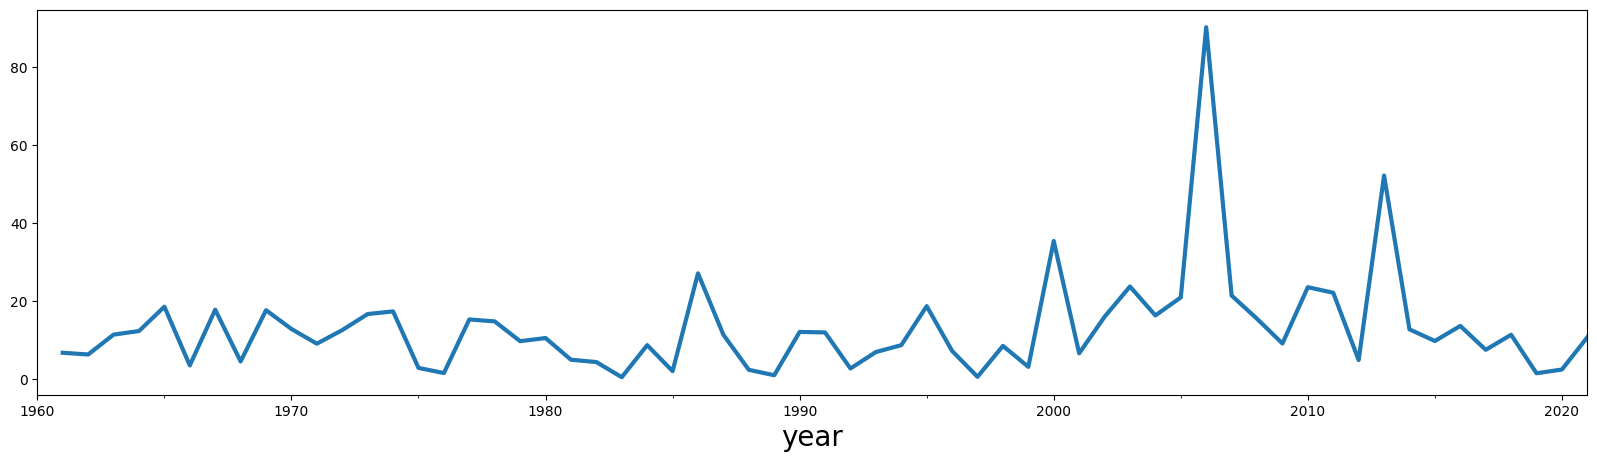

In [168]:
df["GDP_vol"].plot()
plt.show()

In [169]:
# выделим тестовую часть в размере трех последних наблюдений
train_df_vol = df.loc[:"2018-01-01"]
test_df_vol = df.loc["2019-01-01":]
train_df_vol.shape, test_df_vol.shape

((59, 2), (3, 2))

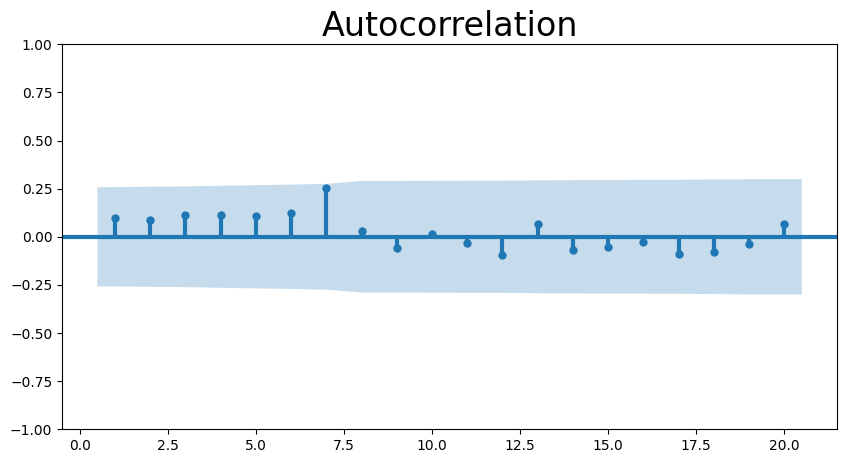

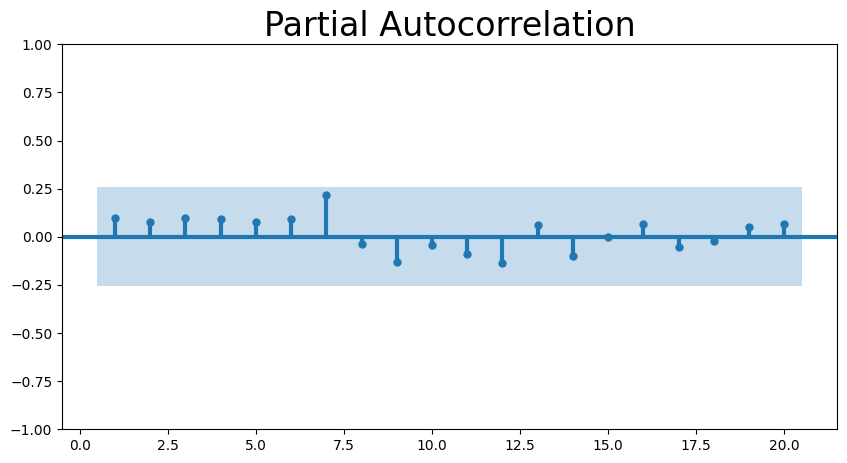

In [170]:
plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_acf(train_df_vol["GDP_vol"][1:], lags=20, zero=False)
plt.show()

sgt.plot_pacf(train_df_vol["GDP_vol"][1:], lags=20, method="ywm", zero=False)
plt.show()

In [171]:
# посредством теста Дики-Фуллера проверим волатильность на стационарность
result = adfuller(train_df_vol["GDP_vol"][1:])
print ('adf: ', result[0])
print ('p-value: ', result[1])
print ('Critical values: ', result[4])
if result[0]> result[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -6.725311059553778
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
ряд стационарен


На основании графиков автокорреляции и частичной автокорреляции получаем:

p=7

q=7

In [172]:
# Используем GARCH модель для предсказания волатильности
garch_df = pd.DataFrame(df["GDP_vol"].loc[df.index])
garch_df.loc[train_df_vol.index, "GDP_vol"] = train_df_vol["GDP_vol"].dropna()
model = arch_model(garch_df["GDP_vol"].dropna(), p=7, q=7, vol="GARCH")
model_results = model.fit(last_obs=test_df_vol.index[0], update_freq=5)
model_results.summary()

Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.38048115955718
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61759052175603
Iteration:     15,   Func. Count:    265,   Neg. LLF: 214.40870465529235
Iteration:     20,   Func. Count:    350,   Neg. LLF: 214.10036198974123
Iteration:     25,   Func. Count:    435,   Neg. LLF: 214.01163861553988
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.00752424273287
            Iterations: 30
            Function evaluations: 509
            Gradient evaluations: 29


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.008
Distribution:                  Normal   AIC:                           460.015
Method:            Maximum Likelihood   BIC:                           492.982
                                        No. Observations:                   58
Date:                Sat, Oct 14 2023   Df Residuals:                       57
Time:                        14:48:24   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8611      1.572      7.547  4.465e-14 [  8.781, 14.942]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.1557     42.422      1.041      0.298    [-38.990,1.273e+02]
alpha[1]   9.7254e-15  7.780e-02  1.250e-13      1.000      [ -0.152,  0.152]
alpha[2]   3.6530e-14  2.308e-02  1.583e-12      1.000 [-4.524e-02,4.524e-02]
alpha[3]   1.0042e-07  6.861e-02  1.464e-06      1.000      [ -0.134,  0.134]
alpha[4]   3.6030e-03  1.495e-02      0.241      0.809 [-2.569e-02,3.289e-02]
alpha[5]   4.8722e-08  1.280e-02  3.807e-06      1.000 [-2.508e-02,2.508e-02]
alpha[6]       0.7321      0.915      0.800      0.424      [ -1.061,  2.525]
alpha[7]       0.1026      0.645      0.159      0.874      [ -1.162,  1.367]
beta[1]    2.9436e-15      0.502  5.865e-15      1.000      [ -0.984,  0.984]
beta[2]    2.4954e-14  6.209e-02  4.019e-13      1.000      [ -0.122,  0.122]
beta[3]    2.7428e-14  2.873e-02  9.545e-13      1.000 [-5.632e-02,5.632e-02]
beta[4]    9.9819e-15  9.130e-02  1.093e-13      1.000      [ -0.179,  0.179]
beta[5]    5.7593e-15  5.262e-02  1.094e-13      1.000      [ -0.103,  0.103]
beta[6]    1.4960e-14  3.017e-02  4.958e-13      1.000 [-5.914e-02,5.914e-02]
beta[7]    2.2071e-15      1.156  1.909e-15      1.000      [ -2.266,  2.266]
=============================================================================

Covariance estimator: robust
"""

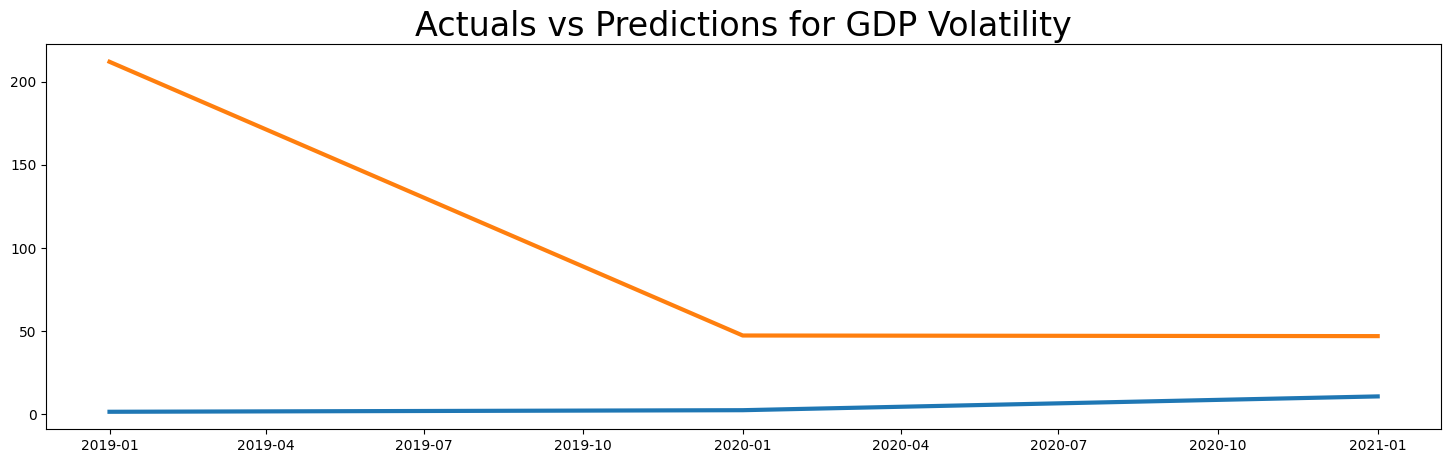

In [173]:
predictions_df = test_df_vol.copy()
# предсказание 
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df_vol.index
]

# визуализируем предсказание по модели GARCH и факт
plt.rcParams["figure.figsize"] = 18, 5
plt.plot(predictions_df["GDP_vol"].abs())
plt.plot(predictions_df["Predictions"])
plt.title("Actuals vs Predictions for GDP Volatility", size=24)
plt.show()

In [174]:
mean_squared_error(
    predictions_df["GDP_vol"].abs(), predictions_df["Predictions"]
)

15856.471092338163

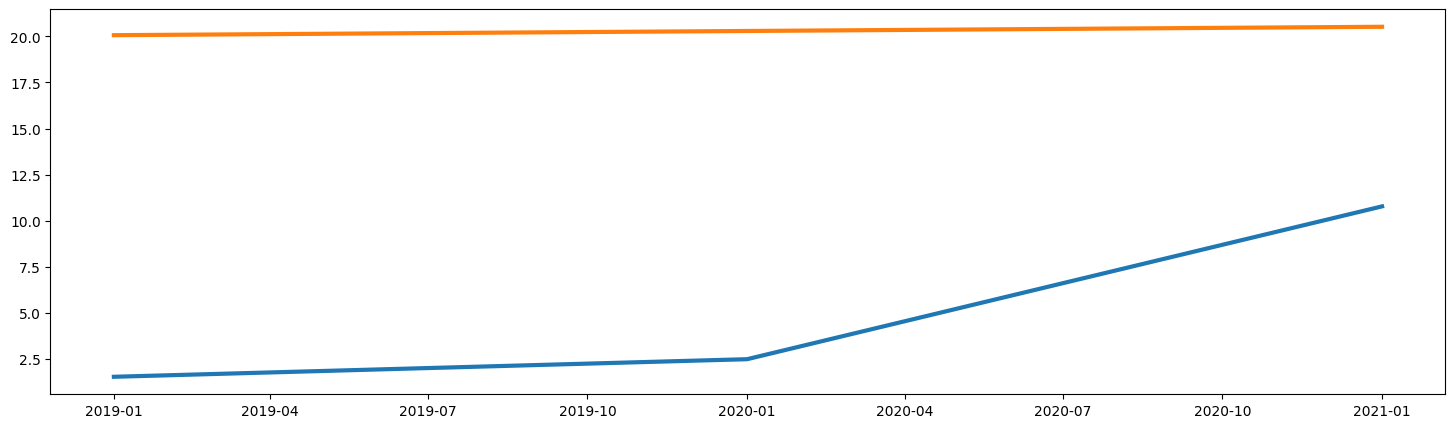

In [183]:
# Используем линейную регрессию для получения прогноза

X_train = pd.DataFrame(range(df["GDP_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df["GDP_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)

y_train = train_df_vol["GDP_vol"].fillna(0)
y_test = test_df_vol["GDP_vol"].fillna(0)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

# Визуализируем предсказание по модели линейной регрессии и факт

plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

Выводы.

Обе модели показали плохое качество прогноза. По всей видимости, слишком маленькая выборка данных.

Конкретно из двух примененных моделей лучший результат показала модель линейной регрессии, ближе к фактическим значениям.